# Inclined ball-drop viscometer

Swetha Vutlapalli & Daniel Duke
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
Department of Mechanical & Aerospace Engineering
Monash University, Australia

In [1]:
import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib notebook


### 1. Functions to solve
Finding the drag coefficient either from the drag force, or from the Reynolds number.


In [2]:
def Cd_from_force_balance(theta, U, friction_coeff, rhoL):
    '''
        theta: inclination angles (degrees)
        U: velocities (m/s)
        friction_coeff: Coefficient of friction (-)
        rhoL: density of the liquid (kg/m3)
    '''
    
    # given constants
    g=9.81 # m/s^2
    rhoBall = 7850. # kg/m^3
    D=1e-3 #m
    
    # calculated constants
    Vball = (4/3.)*np.pi*(D/2.)**3 # volume
    m = rhoBall*g*Vball
    S = 0.25*np.pi*(D**2) # projected area 
    
    # coefficients in equation
    thetaRad = np.array(theta)*(np.pi/180.)
    thetaTerm = np.sin(thetaRad) - friction_coeff*np.cos(thetaRad)
    dynamicPressureS = 0.5*rhoL*(np.array(U)**2)*S
    netWeight = g*(m-rhoL*Vball)
    
    # Parallel to the plane, net force:
    # m.a = netWeight*sin(theta) - Cd*dynamicPressureS - friction_coeff*netWeight*cos(theta)
    # Thus at equilibrium, Cd = netWeight*(sin(theta) - friction_coeff*cos(theta))/dynamicPressureS
    
    return thetaTerm*netWeight/dynamicPressureS
    


In [14]:
def Cd_from_Reynolds(viscosity,U,D=1e-3):
    '''
        viscosity: kinematic viscosity (m^2/s)
        U: velocities (m/s)
        D: diameter [m]
    '''
    
    Re = D*np.array(U)/viscosity

    # https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf
    Cd = (24./Re)
    Cd += (2.6*Re/5.)/(1+(Re/5.)**1.52)
    Cd += (0.411*(Re/2.63e5)**-7.94)/(1+(Re/2.63e5)**-8)
    Cd += (0.25*Re/1e6)/(1+(Re/1e6))
    
    # don't use for Re>1e6
    if isinstance(Cd,np.ndarray):
        Cd[Re>1e6] = np.nan 
    elif Re > 1e6:
        return np.nan
    
    return Cd, Re

### 2. Read Excel data for experiment

In [6]:
# Get the bottom-right table start at cell K9
R134_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R134a_ethanol",\
                        skiprows=7, usecols="K:P").values

R152_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R152a_ethanol",\
                        skiprows=7, usecols="K:P").values

R1234_data = read_excel('Binary Mixture_velocities.xlsx', sheet_name="R1234ze_ethanol",\
                        skiprows=7, usecols="K:P").values

### 3. For pure fluids of known viscosity, find the friction coefficient

In [7]:
# Get the data

# PURE R134a
theta_134 = [ float(th.split(' ')[0]) for th in R134_data[0][1:] ]
U_134 = R134_data[1][1:]
rhoL_134 = 1226.3
visc_134=0.00020805/rhoL_134

# PURE R152a
theta_152 = [ float(th.split(' ')[0]) for th in R152_data[0][1:] ]
U_152 = R134_data[1][1:]
rhoL_152 = 904. # approximate
visc_152= 0.000159/rhoL_152  # approximate

# PURE 1234ze
theta_1234 = [ float(th.split(' ')[0]) for th in R1234_data[0][1:] ]
U_1234 = R134_data[1][1:]
rhoL_1234 = 1170. # approximate
visc_1234= 0.000204/rhoL_1234  # approximate

# PURE Ethanol
theta_eth = theta_134
U_eth = R134_data[9][1:]
rhoL_eth = 789.56
visc_eth=0.0011994/rhoL_eth

# Combine the refrigerant data for a single solution
theta_all = np.concatenate((theta_134,theta_152,theta_1234,theta_eth))
U_all     = np.concatenate((U_134,U_152,U_1234,U_eth))
rhoL_all  = np.concatenate(((rhoL_134,)*len(theta_134),(rhoL_152,)*len(theta_152),(rhoL_1234,)*len(theta_1234),(rhoL_eth,)*len(theta_eth)))
visc_all  = np.concatenate(((visc_134,)*len(theta_134),(visc_152,)*len(theta_152),(visc_1234,)*len(theta_1234),(visc_eth,)*len(theta_eth)))

Reynolds_all=1e-3*np.array(U_all)/visc_all
print("Re =",Reynolds_all)

Re = [1303.8872737323825 1626.3040021778368 1978.4944377391328
 2178.0500954830336 2338.378780365888 1257.7153012781203
 1568.7149259566484 1908.433940546987 2100.9231298023433 2255.57441314047
 1268.7227653607536 1582.4442438601602 1925.1364629964644
 2119.310308417545 2275.3150923809303 88.96768888816798 111.62445990879561
 140.18893949044738 165.51668111271096 189.83588990150128]


<IPython.core.display.Javascript object>


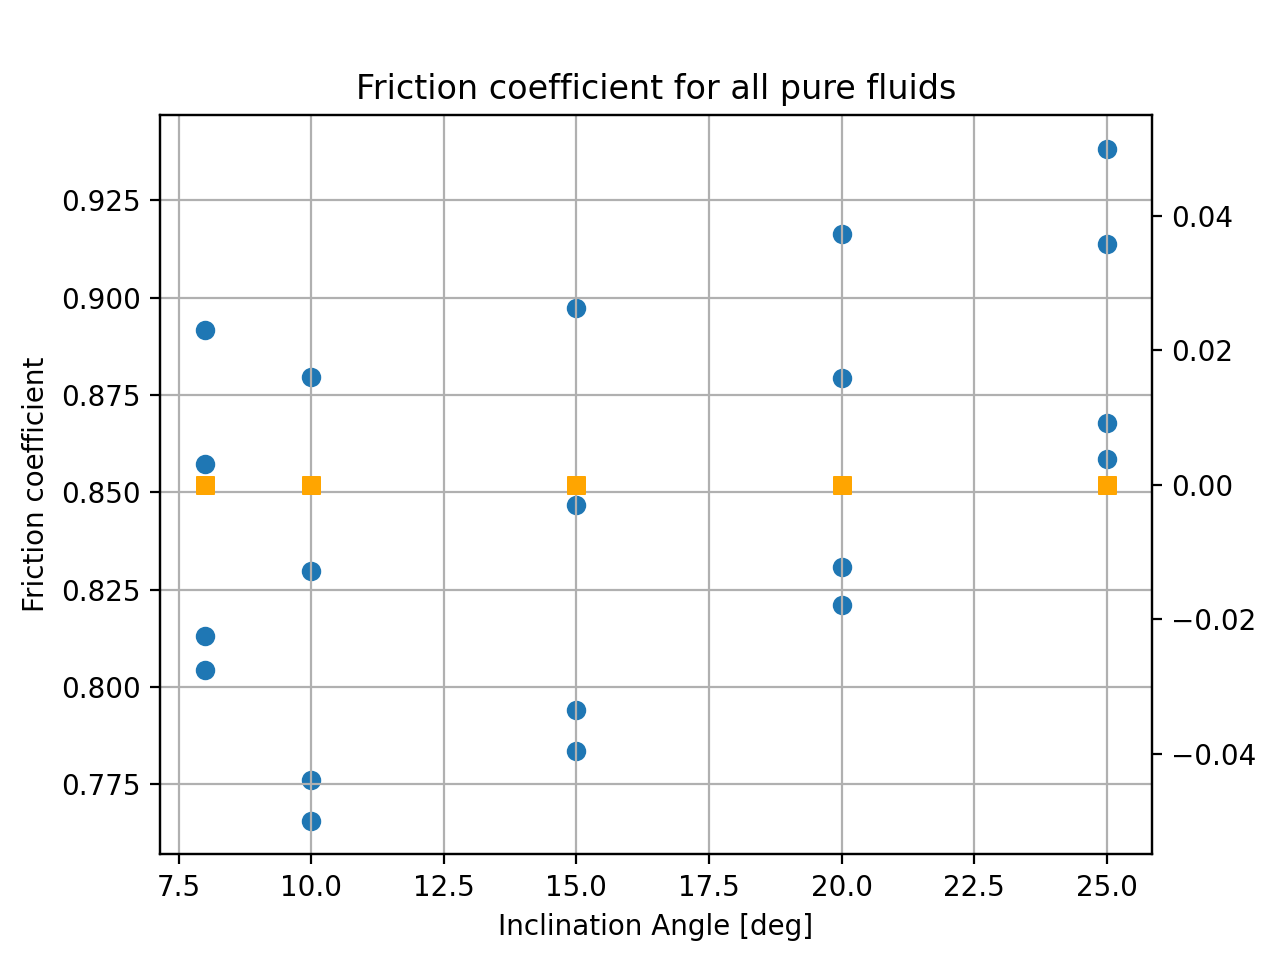

In [96]:
# Perform the calculation

def myfun(friction_coeffs, theta, U, rhoL, visc):
    
    # Allow friction coefficient to vary with theta.
    thetaRad = theta*np.pi/180.
    friction_coeff = friction_coeffs[0]*thetaRad
    
    # Do calculation for Cd.
    Cd1 = Cd_from_force_balance(theta,U,friction_coeff,rhoL)
    Cd2, Re = Cd_from_Reynolds(visc,U)
    return (Cd1 - Cd_all[i])**2

# Find the friction_coeff for every experiment that would give us this drag coefficient
friction_coeff_all=[]
for i in range(len(theta_all)):
    
    res = scipy.optimize.minimize(myfun, x0=(0.1,0,0,0) ,\
                                  args=(theta_all[i], U_all[i], rhoL_all[i], visc_all[i]),\
                                  bounds=[(-100,100),(-1,1),(-1,1),(-1,1)])
    friction_coeff_all.append(res.x)
    
    
friction_coeff_all = np.array(friction_coeff_all)
plt.figure()
plt.title('Friction coefficient for all pure fluids')
plt.ylabel('Friction coefficient'); plt.xlabel('Inclination Angle [deg]')
plt.grid()
plt.scatter(theta_all, friction_coeff_all[:,0], marker='o')
#plt.savefig('/Users/dduke/Desktop/friction1.png')
plt.gca().twinx()
plt.scatter(theta_all, friction_coeff_all[:,1], marker='s',c='orange')
#plt.scatter(theta_all, friction_coeff_all[:,2], marker='s')
#plt.scatter(theta_all, friction_coeff_all[:,3], marker='s')